In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from apyts.constants import *
from test_utils import plot_hists

## Functionsplot_hists

In [3]:
def plot_correlation_matrix(df, fig_ax=None, absolute=True):
    if fig_ax:
        fig, ax = fig_ax
    else:
        fig, ax = plt.subplots()
        
    corrcoefs = np.corrcoef(df.to_numpy().T)
    if absolute:
        corrcoefs = abs(corrcoefs)
    
    im = ax.imshow(corrcoefs, origin="lower", aspect=0.3, vmin=0 if absolute else -1, vmax=1)
    fig.colorbar(im, ax=ax, label='Interactive Colorbar')

    keys = df.columns.tolist()
    ticks = np.arange(len(keys))

    ax.set_xticks(ticks, keys, rotation=45, ha='right')
    ax.set_yticks(ticks, keys)    
    
    ax.set_xticks(ticks-0.5, minor=True)
    ax.set_yticks(ticks-0.5, minor=True)
    
    ax.set_aspect(0.7)
        
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    return fig, ax

In [4]:
def plot_momentum_residual_energy_loss(df, name):
    fig, ax = plt.subplots(2)
    ax[0].set_title("{}: res vs loss".format(name))
    ax[0].scatter(df["RES_P"], df["TOTAL_ELOSS"], alpha=0.3)

    ax[1].set_title("Correlation coefficient")
    plot_correlation_matrix(df[["RES_P","TOTAL_ELOSS"]], (fig, ax[1]))
     
    return fig, ax

In [5]:
def make_dataframe(true_pars, final_pars):
    data = pd.DataFrame()
    
    data[["TRUE_LOC", "TRUE_PHI", "TRUE_QOP"]] = true_pars
    data["TRUE_P"] = abs(1./data["TRUE_QOP"])
    
    data[["FIT_LOC", "FIT_PHI", "FIT_QOP"]] = final_pars
    data["FIT_P"] = abs(1./data["FIT_QOP"])
    
    data[["RES_LOC", "RES_PHI", "RES_QOP"]] = final_pars - true_pars
    data["RES_P"] = abs(1./data["FIT_QOP"]) - abs(1./data["TRUE_QOP"])
    
    return data

In [6]:
def make_surfaces_without_energy_loss(truth_start, sim_results):
    surfaces_without_energy_loss = []
    
    for truth_start, (_, truth_sim, _) in zip(truth_start, sim_results):
        
        last_energy = abs(1./truth_start[eBoundQoP])        
        for surface, truth_pars in enumerate(truth_sim):
            current_energy = abs(1./truth_pars[eBoundQoP])
            
            if current_energy / last_energy < 0.9:
                break
            else:
                last_energy = current_energy
        
        surfaces_without_energy_loss.append(surface)
                
    return np.array(surfaces_without_energy_loss)

In [7]:
def make_max_energy_loss(truth_start, sim_results):
    max_energy_losses = np.zeros(len(truth_start))
    
    for i, (truth_start, (_, truth_sim, _)) in enumerate(zip(truth_start, sim_results)):
        last_energy = abs(1./truth_start[eBoundQoP])   
        
        for surface, truth_pars in enumerate(truth_sim):
            current_energy = abs(1./truth_pars[eBoundQoP])
            loss = last_energy - current_energy
            
            max_energy_losses[i] = max(loss, max_energy_losses[i])
            last_energy = current_energy
        
    return max_energy_losses

## Import & compute data

In [8]:
input_path = Path("output/20230117_132335-500particles")

In [9]:
with open(input_path / "sim_result.pickle", "rb") as f:
    data = pickle.load(f)
    true_pars = data["true_pars"]
    sim_results = data["sim_results"]
with open(input_path / "start_parameters.pickle", "rb") as f:
    data = pickle.load(f)
    start_pars = data["parameters"]
    start_covs = data["covs"]

In [10]:
energy_loss = np.array([
    abs(1./truth_start[eBoundQoP]) - abs(1./truth_sim[-1][eBoundQoP]) for (_, truth_sim, _), truth_start in zip(sim_results, true_pars)
])

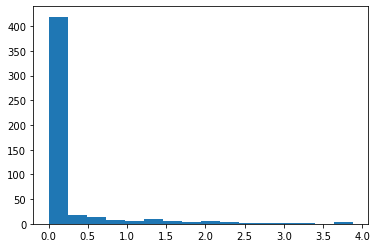

In [11]:
_ = plt.hist(energy_loss, bins="rice")

In [12]:
surfaces_without_energy_loss = make_surfaces_without_energy_loss(true_pars, sim_results)
surfaces_without_energy_loss.shape

(500,)

<BarContainer object of 9 artists>

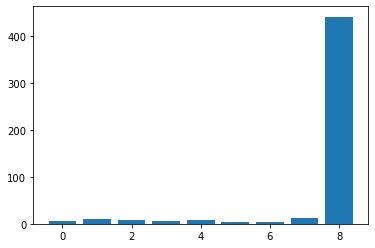

In [13]:
plt.bar(*np.unique(surfaces_without_energy_loss, return_counts=True))

In [14]:
max_energy_loss = make_max_energy_loss(true_pars, sim_results)

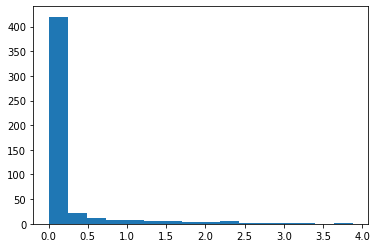

In [15]:
_ = plt.hist(max_energy_loss, bins="rice")

## Kalman Fitter

In [16]:
with open(input_path / "kf_fit_result.pickle", "rb") as f:
    kf_fit_results = pickle.load(f)["fit_result"]

In [17]:
kf_mask = np.array([ False if data is None else True for data in kf_fit_results ])
kf_fit_results = [ d for d in kf_fit_results if d is not None ]
kf_sim_results = [ d for d, keep in zip(sim_results, kf_mask) if keep ]
kf_final_pars = np.stack([ data[0][0] for data in kf_fit_results ])

kf_data = make_dataframe(true_pars[kf_mask], kf_final_pars)
kf_data["TOTAL_ELOSS"] = energy_loss[kf_mask]
kf_data["MAX_ELOSS"] = max_energy_loss[kf_mask]
kf_data["SURF_NO_ELOSS"] = surfaces_without_energy_loss[kf_mask]
#kf_data = kf_data[ kf_data["ELOSS"] > -0.1 ]

In [18]:
kf_data.head(5)

,TRUE_LOC,TRUE_PHI,TRUE_QOP,TRUE_P,FIT_LOC,FIT_PHI,FIT_QOP,FIT_P,RES_LOC,RES_PHI,RES_QOP,RES_P,TOTAL_ELOSS,MAX_ELOSS,SURF_NO_ELOSS
0,0.0,1.570796,-0.25,4.0,-0.018520,1.570636,-0.250930,3.985174,-0.018520,-0.000161,-0.000930,-0.014826,1.553529e-02,1.553529e-02,8
1,0.0,1.570796,-0.25,4.0,-0.004111,1.570743,-0.250178,3.997146,-0.004111,-0.000054,-0.000178,-0.002854,1.489475e-12,1.482370e-12,8
2,0.0,1.570796,-0.25,4.0,0.002150,1.570816,-0.249916,4.001347,0.002150,0.000020,0.000084,0.001347,6.519652e-05,6.519652e-05,8
3,0.0,1.570796,-0.25,4.0,0.010536,1.570839,-0.249868,4.002107,0.010536,0.000043,0.000132,0.002107,2.417465e-07,2.417458e-07,8
4,0.0,1.570796,-0.25,4.0,-0.005139,1.570744,-0.250289,3.995386,-0.005139,-0.000052,-0.000289,-0.004614,2.002678e-01,2.002678e-01,8


Text(0.5, 0.98, 'Residuals KF')

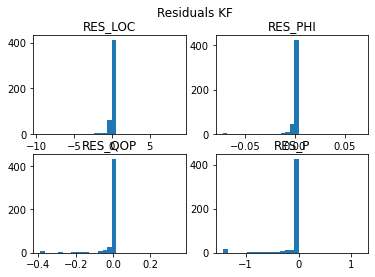

In [19]:
fig, ax = plot_hists(kf_data.filter(like="RES_"), bins="rice")
fig.suptitle("Residuals KF")

Text(0.5, 0.98, 'KF correlation matrix')

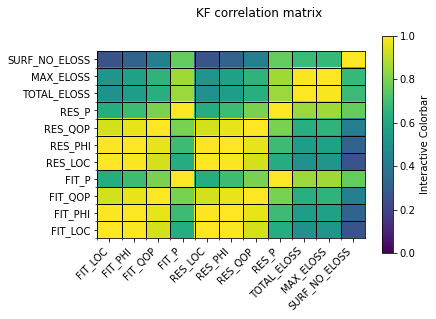

In [20]:
fig, ax = plot_correlation_matrix(kf_data.filter(regex="^(?!.*TRUE).*$", axis=1))
fig.suptitle("KF correlation matrix")

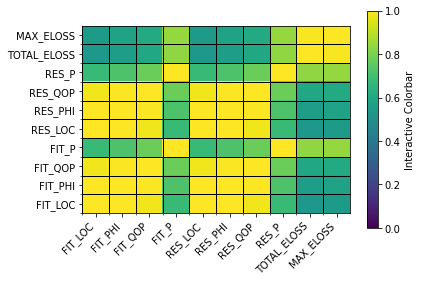

In [21]:
fig, ax = plot_correlation_matrix(kf_data[ kf_data["SURF_NO_ELOSS"] > 0 ].filter(regex="^(?!.*(TRUE|SURF)).*$", axis=1))

## GSF 

In [22]:
with open(input_path / "gsf_fit_result.pickle", "rb") as f:
    gsf_fit_results = pickle.load(f)["fit_result"]

In [23]:
gsf_mask = np.array([ False if data is None else True for data in gsf_fit_results ])
gsf_fit_results = [ d for d in gsf_fit_results if d is not None ]
gsf_sim_results = [ d for d, keep in zip(sim_results, gsf_mask) if keep ]
gsf_final_pars = np.stack([ max(cmps, key=lambda c: c[0])[1] for cmps, _, _, _ in gsf_fit_results ])

gsf_data = make_dataframe(true_pars[gsf_mask], gsf_final_pars)
gsf_data["TOTAL_ELOSS"] = energy_loss[gsf_mask]
gsf_data["MAX_ELOSS"] = max_energy_loss[gsf_mask]
gsf_data["SURF_NO_ELOSS"] = surfaces_without_energy_loss[gsf_mask]
#gsf_data = gsf_data[ gsf_data["ELOSS"] > -0.1 ]

In [24]:
gsf_data.head(5)

,TRUE_LOC,TRUE_PHI,TRUE_QOP,TRUE_P,FIT_LOC,FIT_PHI,FIT_QOP,FIT_P,RES_LOC,RES_PHI,RES_QOP,RES_P,TOTAL_ELOSS,MAX_ELOSS,SURF_NO_ELOSS
0,0.0,1.570796,-0.25,4.0,-0.009989,1.570722,-0.250287,3.995410,-0.009989,-0.000074,-0.000287,-0.004590,1.553529e-02,1.553529e-02,8
1,0.0,1.570796,-0.25,4.0,-0.006170,1.570736,-0.250190,3.996965,-0.006170,-0.000060,-0.000190,-0.003035,1.489475e-12,1.482370e-12,8
2,0.0,1.570796,-0.25,4.0,-0.000024,1.570809,-0.249930,4.001128,-0.000024,0.000013,0.000070,0.001128,6.519652e-05,6.519652e-05,8
3,0.0,1.570796,-0.25,4.0,0.009499,1.570836,-0.249869,4.002097,0.009499,0.000040,0.000131,0.002097,2.417465e-07,2.417458e-07,8
4,0.0,1.570796,-0.25,4.0,-0.007916,1.570735,-0.250305,3.995121,-0.007916,-0.000061,-0.000305,-0.004879,2.002678e-01,2.002678e-01,8


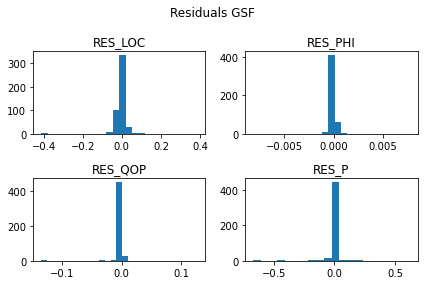

In [25]:
fig, ax = plot_hists(gsf_data.filter(like="RES_"), bins="rice")
fig.suptitle("Residuals GSF")
fig.tight_layout()

Text(0.5, 0.98, 'GSF correlation matrix')

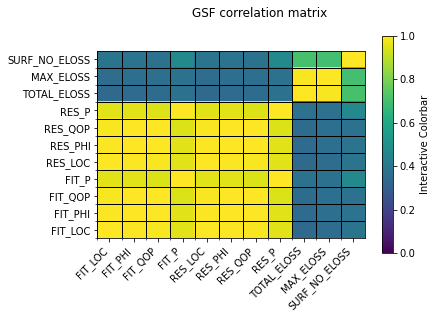

In [26]:
fig, ax = plot_correlation_matrix(gsf_data.filter(regex="^(?!.*TRUE).*$", axis=1))
fig.suptitle("GSF correlation matrix")

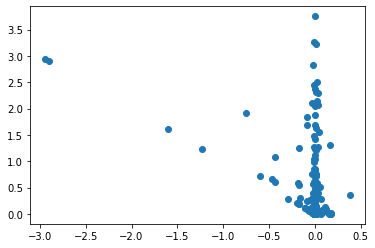

In [27]:
plt.scatter(gsf_data["RES_P"], gsf_data["TOTAL_ELOSS"])

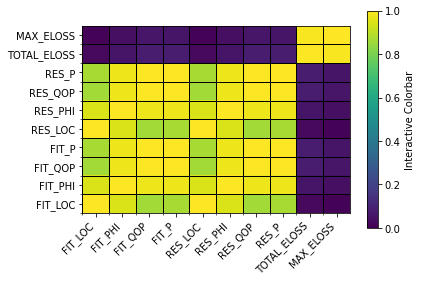

In [28]:
fig, ax = plot_correlation_matrix(gsf_data[ gsf_data["SURF_NO_ELOSS"] > 0 ].filter(regex="^(?!.*(TRUE|SURF)).*$", axis=1))

In [29]:
test = gsf_data[ gsf_data["RES_P"] > 0.025 ]
test = test[ test["TOTAL_ELOSS"] < 0.25 ]

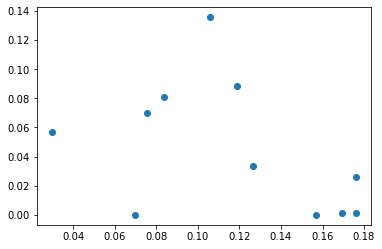

In [30]:
plt.scatter(test["RES_P"], test["TOTAL_ELOSS"])

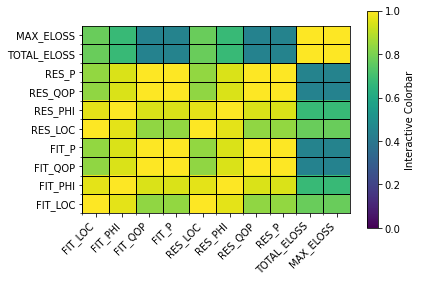

In [31]:
fig, ax = plot_correlation_matrix(test.filter(regex="^(?!.*(TRUE|SURF)).*$", axis=1))

In [32]:
test

,TRUE_LOC,TRUE_PHI,TRUE_QOP,TRUE_P,FIT_LOC,FIT_PHI,FIT_QOP,FIT_P,RES_LOC,RES_PHI,RES_QOP,RES_P,TOTAL_ELOSS,MAX_ELOSS,SURF_NO_ELOSS
154,0.0,1.570796,-0.25,4.0,0.039111,1.571099,-0.248162,4.029629,0.039111,0.000302,0.001838,0.029629,0.056712,0.056712,8
222,0.0,1.570796,-0.25,4.0,0.111064,1.572018,-0.239853,4.169225,0.111064,0.001222,0.010147,0.169225,0.001021,0.001021,8
227,0.0,1.570796,-0.25,4.0,0.030271,1.571296,-0.243548,4.105968,0.030271,0.000499,0.006452,0.105968,0.135495,0.135495,8
229,0.0,1.570796,-0.25,4.0,0.094032,1.571808,-0.242330,4.126609,0.094032,0.001011,0.007670,0.126609,0.033362,0.033362,8
258,0.0,1.570796,-0.25,4.0,0.091527,1.571958,-0.239462,4.176026,0.091527,0.001162,0.010538,0.176026,0.026243,0.026231,8
314,0.0,1.570796,-0.25,4.0,0.063488,1.571417,-0.245705,4.069917,0.063488,0.000620,0.004295,0.069917,0.000035,0.000035,8
317,0.0,1.570796,-0.25,4.0,0.057533,1.571457,-0.244879,4.083652,0.057533,0.000661,0.005121,0.083652,0.080718,0.080718,8
337,0.0,1.570796,-0.25,4.0,0.064920,1.571507,-0.242800,4.118614,0.064920,0.000710,0.007200,0.118614,0.088629,0.088610,8
358,0.0,1.570796,-0.25,4.0,0.099318,1.571917,-0.240556,4.157036,0.099318,0.001120,0.009444,0.157036,0.000002,0.000002,8
456,0.0,1.570796,-0.25,4.0,0.027372,1.571281,-0.245375,4.075399,0.027372,0.000484,0.004625,0.075399,0.069866,0.069840,8
